# Importing Libraries

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings("ignore")

# Load  PreProcessed data 

In [2]:
df_train_processed = pd.read_csv(r'C:\Users\dell\Desktop\ELEVVO INTERN\Loan Approval Prediction\Data PreProcessing and Feature Engineering\preprocessed_train_data.csv')    
df_test_processed = pd.read_csv(r'C:\Users\dell\Desktop\ELEVVO INTERN\Loan Approval Prediction\Data PreProcessing and Feature Engineering\preprocessed_test_data.csv')

In [5]:
X_train = df_train_processed.drop('loan_status', axis=1)
y_train = df_train_processed['loan_status']
X_test = df_test_processed.drop('loan_status', axis=1)
y_test = df_test_processed['loan_status']

# Feature Selection

In [9]:
# Manually Selected Features
selected_features = ['cibil_score', 'loan_income_ratio','dti_ratio','asset_to_loan_ratio','total_assets_value', 'income_annum','loan_amount','education','self_employed']

In [ ]:
# SelectKBest 
selector = SelectKBest(score_func=f_classif, k=9)
selector.fit(X_train, y_train)

selected_kbest_features = X_train.columns[selector.get_support()].tolist()
print("Selected features by SelectKBest:", selected_kbest_features)

Selected features by SelectKBest: ['education', 'self_employed', 'loan_term', 'cibil_score', 'residential_assets_value', 'loan_income_ratio', 'monthly_loan_payment', 'dti_ratio', 'asset_to_loan_ratio']


In [13]:
# RFE
estimator = LogisticRegression(max_iter=1000)
rfe = RFE(estimator, n_features_to_select=9)
rfe.fit(X_train, y_train)

selected_rfe_features = X_train.columns[rfe.support_].tolist()
print("Selected features by RFE:", selected_rfe_features)

Selected features by RFE: ['no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_term', 'cibil_score', 'loan_income_ratio', 'dti_ratio', 'asset_to_loan_ratio']


# Model Development

In [15]:
# Feature Sets
feature_sets = {
    'manual': selected_features,
    'selectkbest': selected_kbest_features,
    'rfe': selected_rfe_features,
    'all': X_train.columns.tolist()
}

In [ ]:
# Models and their hyperparameter grids
models = {
    'LogisticRegression': (
        LogisticRegression(max_iter=1000, solver='liblinear'),
        {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }
    ),
    'DecisionTree': (
        DecisionTreeClassifier(random_state=42),
        {
            'max_depth': [1,2, 3],
            'min_samples_split': [50, 100],
            'min_samples_leaf': [20, 50],
        }
    )
}


In [30]:
results = {}

for model_name, (model, param_grid) in models.items():
    results[model_name] = {}
    for set_name, features in feature_sets.items():
        # Select features
        X_tr = X_train[features]
        X_te = X_test[features]

        # Grid search with cross-validation
        grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid.fit(X_tr, y_train)

        # Predictions
        y_train_pred = grid.predict(X_tr)
        y_test_pred = grid.predict(X_te)

        # Scores
        best_cv_score = grid.best_score_
        train_score = accuracy_score(y_train, y_train_pred)  
        test_score = grid.score(X_te, y_test)

        # Classification report 
        test_class_report = classification_report(y_test, y_test_pred, output_dict=True)

        # Store in results
        results[model_name][set_name] = {
            'best_params': grid.best_params_,
            'cv_score': best_cv_score,
            'train_score': train_score,
            'test_score': test_score,
            'classification_report': test_class_report 
        }

        # Print results
        print(f"{model_name} with {set_name} features:")
        print("  Best Params:", grid.best_params_)
        print("  CV Score (mean cross-validation):", best_cv_score)
        print("  Train Score:", train_score)
        print("  Test Score:", test_score)
        print("  Test Classification Report:")
        print(classification_report(y_test, y_test_pred))
        print("-" * 60)

LogisticRegression with manual features:
  Best Params: {'C': 0.1, 'penalty': 'l1'}
  CV Score (mean cross-validation): 0.9422169811320755
  Train Score: 0.9438679245283019
  Test Score: 0.9262295081967213
  Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       536
           1       0.87      0.94      0.90       318

    accuracy                           0.93       854
   macro avg       0.92      0.93      0.92       854
weighted avg       0.93      0.93      0.93       854

------------------------------------------------------------
LogisticRegression with selectkbest features:
  Best Params: {'C': 1, 'penalty': 'l1'}
  CV Score (mean cross-validation): 0.942688679245283
  Train Score: 0.9431603773584906
  Test Score: 0.9332552693208431
  Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       536
           1       0.89      

# Visualization for Comparing Both Models

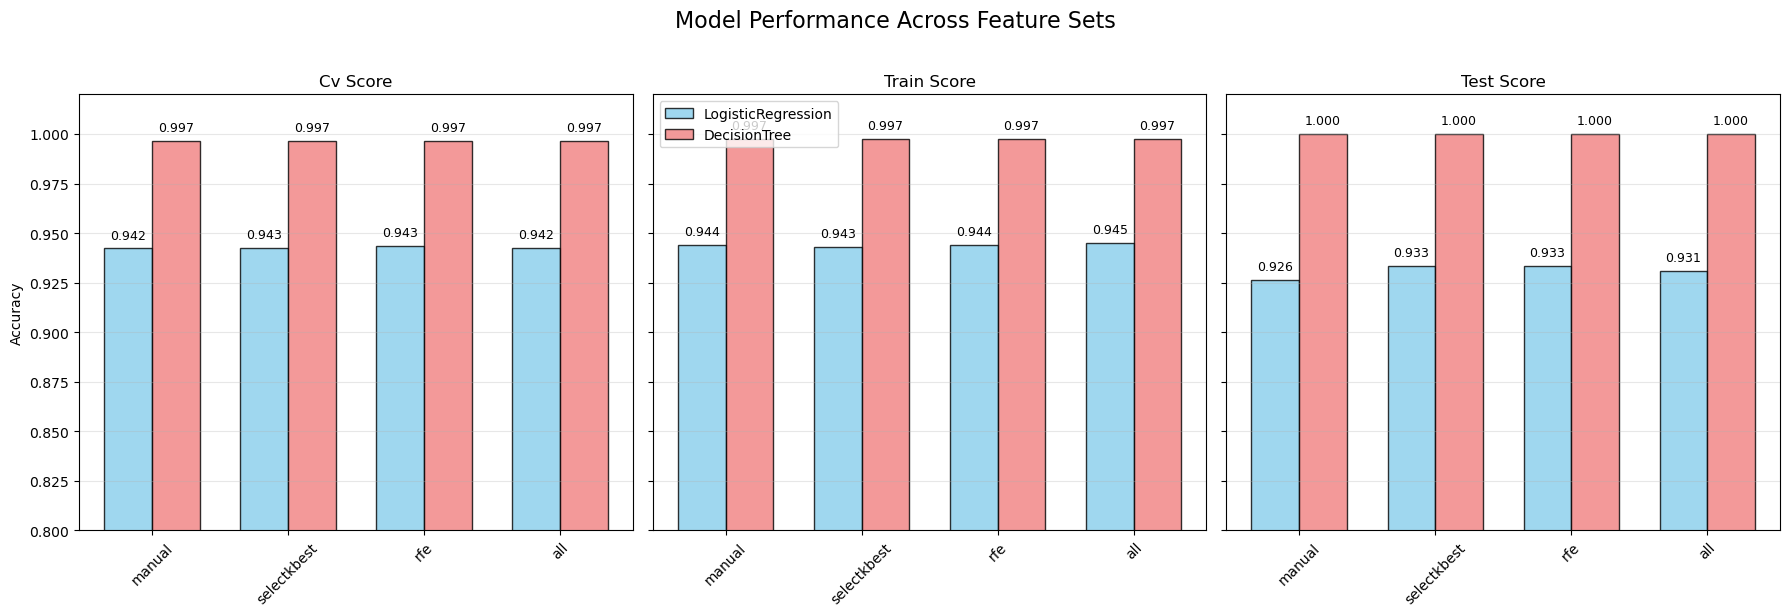

In [36]:
# Model Accuracy Comparison (Train, CV, Test)

colors = {'LogisticRegression': 'skyblue', 'DecisionTree': 'lightcoral'}
positions = np.arange(len(feature_sets))

# Width for grouped bars
bar_width = 0.35

# Subplots for CV, Train, and Test scores
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, score_type in enumerate(['cv_score', 'train_score', 'test_score']):
    ax = axes[i]
    for j, model in enumerate(models):
        scores = [results[model][fs][score_type] for fs in feature_sets]
        ax.bar(positions + j * bar_width, scores, bar_width,
               label=model, color=colors[model], edgecolor='black', alpha=0.8)

    ax.set_title(f'{score_type.replace("_", " ").title()}')
    ax.set_xticks(positions + bar_width / 2)
    ax.set_xticklabels(feature_sets, rotation=45)
    ax.set_ylim(0.8, 1.02)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for x_pos, (lr_score, dt_score) in enumerate(zip(
        [results['LogisticRegression'][fs][score_type] for fs in feature_sets],
        [results['DecisionTree'][fs][score_type] for fs in feature_sets])):
        ax.text(x_pos + 0 * bar_width, lr_score + 0.005, f'{lr_score:.3f}', ha='center', fontsize=9)
        ax.text(x_pos + 1 * bar_width, dt_score + 0.005, f'{dt_score:.3f}', ha='center', fontsize=9)

axes[0].set_ylabel('Accuracy')
axes[1].legend()
plt.suptitle('Model Performance Across Feature Sets', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

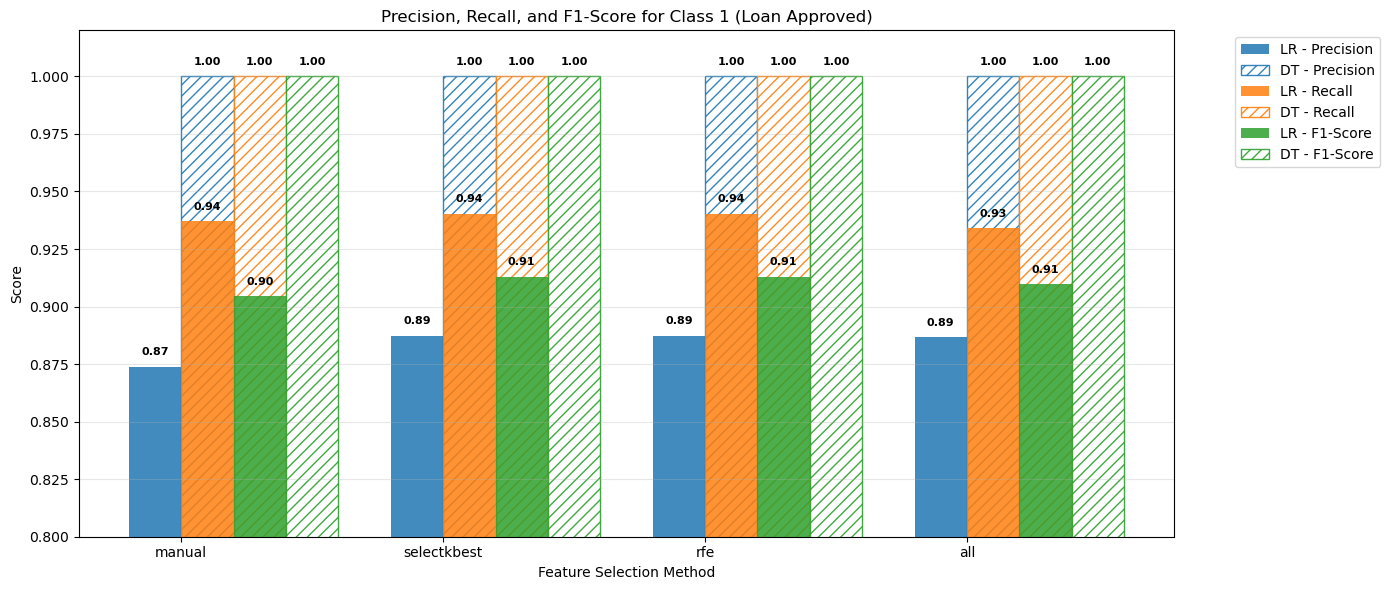

In [ ]:
# Precision, Recall, F1-Score for Class 1 (Approved)

metrics = ['precision', 'recall', 'f1-score']
colors = ['C0', 'C1', 'C2']  
x = np.arange(len(feature_sets))
width = 0.2  

plt.figure(figsize=(14, 6))

# Logistic Regression and Decision Tree values for class '1'
for i, metric in enumerate(metrics):
    lr_vals = [results['LogisticRegression'][fs]['classification_report']['1'][metric] for fs in feature_sets]
    dt_vals = [results['DecisionTree'][fs]['classification_report']['1'][metric] for fs in feature_sets]

    # Plot Logistic Regression
    plt.bar(x - width/2 + i*width, lr_vals, width, label=f'LR - {metric.title()}', color=colors[i], alpha=0.85)
    # Plot Decision Tree with edge and hatch
    plt.bar(x + width/2 + i*width, dt_vals, width, label=f'DT - {metric.title()}', color='white', edgecolor=colors[i], hatch='///', alpha=0.9)

plt.xlabel('Feature Selection Method')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Class 1 (Loan Approved)')
plt.xticks(x, list(feature_sets.keys()))
plt.ylim(0.8, 1.02)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)

# Add text labels
for i in range(len(feature_sets)):
    for j, metric in enumerate(metrics):
        val_lr = results['LogisticRegression'][list(feature_sets.keys())[i]]['classification_report']['1'][metric]
        val_dt = results['DecisionTree'][list(feature_sets.keys())[i]]['classification_report']['1'][metric]
        plt.text(i - width/2 + j*width, val_lr + 0.005, f'{val_lr:.2f}', ha='center', fontsize=8, fontweight='bold')
        plt.text(i + width/2 + j*width, val_dt + 0.005, f'{val_dt:.2f}', ha='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()